# Models and Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

In [2]:
train_file = '../data/processed/hourly_train.csv'
test_file = '../data/processed/hourly_test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

# Ensure 'date' is in datetime format and set as index
train_data['date'] = pd.to_datetime(train_data['date'])  
train_data.set_index('date', inplace=True)
train_data = train_data.asfreq('h')

test_data['date'] = pd.to_datetime(test_data['date'])  
test_data.set_index('date', inplace=True)
test_data = test_data.asfreq('h')

print(f'Train size: {train_data.shape}, Test size: {test_data.shape}')

Train size: (3144, 31), Test size: (120, 31)


## Sarimax Model without Regressors

C:\Users\yafa917\AppData\Local\pypoetry\Cache\virtualenvs\time-series-prediction-energy-nKuvrQjy-py3.13\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


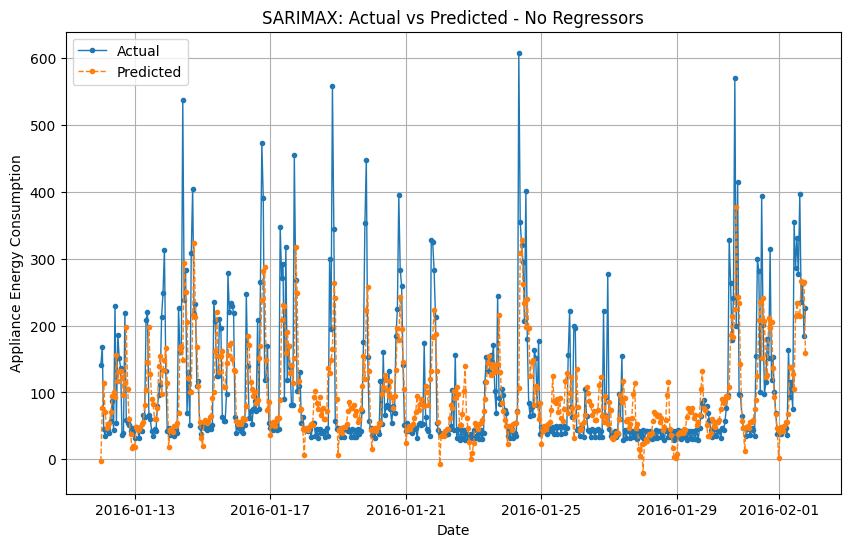

,coef,std err,z,P>|z|,[0.025,0.975]
is_weekend,9.1061,4.634,1.965,0.049,0.023,18.189
absent_day,-29.6275,10.692,-2.771,0.006,-50.584,-8.671
day_of_week_1,-2.7091,7.973,-0.340,0.734,-18.336,12.918
day_of_week_2,3.3467,9.662,0.346,0.729,-15.591,22.285
day_of_week_3,-1.8396,8.934,-0.206,0.837,-19.349,15.670
day_of_week_4,15.4913,8.348,1.856,0.064,-0.871,31.853
day_of_week_5,6.4332,4.974,1.293,0.196,-3.316,16.182
day_of_week_6,2.6729,5.360,0.499,0.618,-7.832,13.177
hour_1,25.3730,26.173,0.969,0.332,-25.926,76.671
hour_2,31.4156,38.017,0.826,0.409,-43.097,105.928


In [3]:
# SARIMA Model Parameters without regresssors
categorical_vars = train_data[['day_of_week', 'hour', 'is_weekend', 'absent_day']]
categorical_vars = pd.get_dummies(categorical_vars, columns=['day_of_week', 'hour'], drop_first=True)
categorical_vars = categorical_vars.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

model1 = SARIMAX(train_data['Appliances'], 
                exog = categorical_vars,
                order=(2, 0, 0),              # AR(2), No differencing, No MA
                seasonal_order=(1, 0, 0, 24), # Seasonal AR(1) with 24-hour periodicity
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the SARIMA Model
sarima_result1 = model1.fit(disp=False)
# align indices
fitted_values = sarima_result1.fittedvalues
fitted_values.index = train_data.index[fitted_values.shape[0] * -1:] 

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(train_data['Appliances'].iloc[:500], label='Actual', marker='.', linewidth=1)
plt.plot(fitted_values.iloc[:500], label='Predicted', marker='.', linewidth=1, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('SARIMAX: Actual vs Predicted - No Regressors')
plt.legend()
plt.grid(True)
plt.show()

# Model Summary
model_summary1 = sarima_result1.summary()
model_summary1.tables[1]  

### Forecast using Sarimax Model

In [4]:
# Prepare prediction dataset
test_categorical_vars = test_data[['day_of_week', 'hour', 'is_weekend', 'absent_day']]
test_categorical_vars = pd.get_dummies(test_categorical_vars, columns=['day_of_week', 'hour'], drop_first=True)
test_categorical_vars = test_categorical_vars.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
test_categorical_vars = test_categorical_vars.reindex(columns=categorical_vars.columns, fill_value=0)

# Verify the structure
print(test_categorical_vars.columns)
print(test_categorical_vars.head())


Index(['is_weekend', 'absent_day', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')
                     is_weekend  absent_day  day_of_week_1  day_of_week_2  \
date                                                                        
2016-05-22 00:00:00           1           0              0              0   
2016-05-22 01:00:00           1           0              0              0   
2016-05-22 02:00:00           1           0              0              0   
2016-05-22 03:00:00           1           0              0              0   
2016-05-22 04:00:00           1           0              0              0   

                     

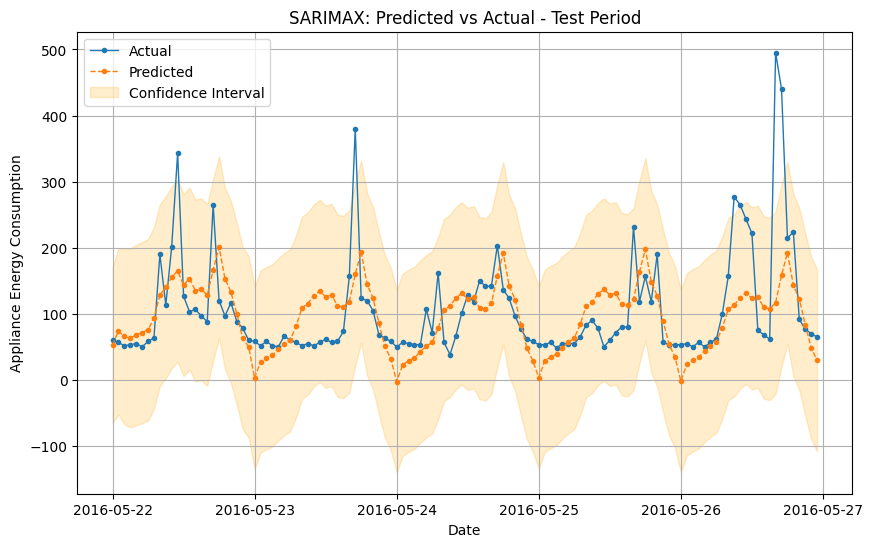

In [5]:
# Generate predictions for the test period
forecast_result1 = sarima_result1.get_forecast(steps=len(test_data), exog=test_categorical_vars)

# Extract predicted values and confidence intervals
forecasted_values1 = forecast_result1.predicted_mean
forecast_conf_int1 = forecast_result1.conf_int()

# Align indices with test data
forecasted_values1.index = test_data.index
forecast_conf_int1.index = test_data.index

# Plot Actual vs Predicted for the test period
plt.figure(figsize=(10, 6))
plt.plot(test_data['Appliances'], label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(forecasted_values1, label='Predicted', marker='.', linestyle='--', linewidth=1)
plt.fill_between(
    forecast_conf_int1.index,
    forecast_conf_int1.iloc[:, 0],
    forecast_conf_int1.iloc[:, 1],
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('SARIMAX: Predicted vs Actual - Test Period')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Evaluate Forecast Accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error
forecast_horizon = 120

mape1 = (abs((test_data['Appliances'].iloc[:forecast_horizon] - forecasted_values1) /
            test_data['Appliances'].iloc[:forecast_horizon]).mean()) * 100

r2_1 = r2_score(test_data['Appliances'].iloc[:forecast_horizon], forecasted_values1)

error_metrics_df = pd.DataFrame(columns=['Model', 'MAPE', 'R2'])

# Update the error metrics DataFrame
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'SARIMAX without Regressors',
    'MAPE': mape1,
    'R2': r2_1
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)


                        Model       MAPE        R2
0  SARIMAX without Regressors  44.958052  0.257549


C:\Users\yafa917\AppData\Local\Temp\ipykernel_22344\2733666829.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{


## Sarimax Model with External Regressors

The two external regressors with the highest correlation with the target variable are included in the model: lights and outside humidity.

C:\Users\yafa917\AppData\Local\pypoetry\Cache\virtualenvs\time-series-prediction-energy-nKuvrQjy-py3.13\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


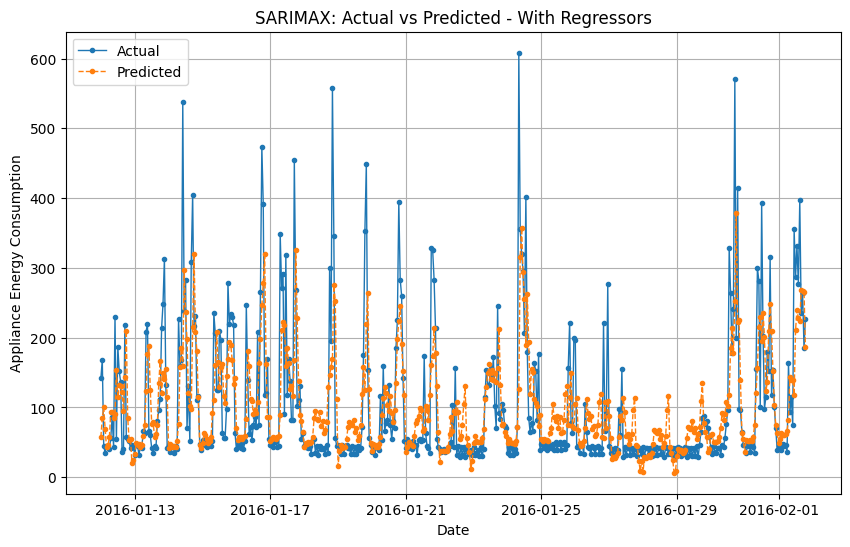

,coef,std err,z,P>|z|,[0.025,0.975]
lights,1.7455,0.174,10.058,0.000,1.405,2.086
RH_out,0.4543,0.128,3.540,0.000,0.203,0.706
is_weekend,2.4348,4.826,0.505,0.614,-7.024,11.894
absent_day,-29.3682,11.766,-2.496,0.013,-52.430,-6.306
day_of_week_1,-13.3278,8.584,-1.553,0.121,-30.152,3.497
day_of_week_2,-9.1775,9.809,-0.936,0.349,-28.403,10.048
day_of_week_3,-13.3467,9.012,-1.481,0.139,-31.011,4.317
day_of_week_4,6.3177,8.014,0.788,0.430,-9.389,22.024
day_of_week_5,2.3759,4.877,0.487,0.626,-7.183,11.935
day_of_week_6,0.0588,5.656,0.010,0.992,-11.027,11.145


In [7]:
# Regressors
exog_vars = train_data[['day_of_week', 'hour', 'is_weekend', 'absent_day']]
exog_vars = pd.get_dummies(exog_vars, columns=['day_of_week', 'hour'], drop_first=True)
exog_vars = pd.concat([train_data[['lights', 'RH_out']], exog_vars], axis=1)
exog_vars = exog_vars.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# SARIMA Model Parameters without regresssors
model2 = SARIMAX(train_data['Appliances'], 
                exog=exog_vars,
                order=(2, 0, 0),              # AR(2), No differencing, No MA
                seasonal_order=(1, 0, 0, 24), # Seasonal AR(1) with 24-hour periodicity
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the SARIMA Model
sarima_result2 = model2.fit(disp=False)
# align indices
fitted_values = sarima_result2.fittedvalues
fitted_values.index = train_data.index[fitted_values.shape[0] * -1:] 

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(train_data['Appliances'].iloc[:500], label='Actual', marker='.', linewidth=1)
plt.plot(fitted_values.iloc[:500], label='Predicted', marker='.', linewidth=1, linestyle='--')
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('SARIMAX: Actual vs Predicted - With Regressors')
plt.legend()
plt.grid(True)
plt.show()

# Model Summary
model_summary2 = sarima_result2.summary()
model_summary2.tables[1]  

### Forecast using Sarimax Model with Forecasted Regressors

#### Forecast Regressors

In [8]:
# Define forecast horizon and frequency
forecast_horizon = 120
forecast_start_time = train_data.index[-1]  # Last timestamp in training data
forecast_dates = pd.date_range(
    start=forecast_start_time,
    periods=forecast_horizon + 1,  # Include the starting timestamp
    freq='h'  # Assuming hourly frequency
)[1:]  # Exclude the starting timestamp

# Forecast regressors
lights_model = SARIMAX(train_data['lights'], 
                exog = categorical_vars,
                order=(1, 0, 0),              # AR(1), No differencing, No MA
                seasonal_order=(1, 0, 0, 24), # Seasonal AR(1) with 24-hour periodicity
                enforce_stationarity=False,
                enforce_invertibility=False)

lights_result = lights_model.fit(disp=False)
lights_forecast = pd.Series(lights_result.forecast(steps=forecast_horizon, exog=test_categorical_vars), index=forecast_dates)
lights_forecast = lights_forecast.clip(lower=0)

humid_model = SARIMAX(train_data['RH_out'], 
                exog = categorical_vars,
                order=(1, 0, 0),              # AR(1), No differencing, No MA
                seasonal_order=(1, 0, 0, 24), # Seasonal AR(1) with 24-hour periodicity
                enforce_stationarity=False,
                enforce_invertibility=False)                      
humid_result = humid_model.fit(disp=False)
humid_forecast = pd.Series(humid_result.forecast(steps=forecast_horizon, exog=test_categorical_vars), index=forecast_dates)
humid_forecast = humid_forecast.clip(lower=0)

# Combine into a DataFrame with the correct datetime index
forecasted_regressors = pd.DataFrame({
    'lights': lights_forecast,
    'RH_out': humid_forecast
})

forecasted_regressors.head(5)


C:\Users\yafa917\AppData\Local\pypoetry\Cache\virtualenvs\time-series-prediction-energy-nKuvrQjy-py3.13\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yafa917\AppData\Local\pypoetry\Cache\virtualenvs\time-series-prediction-energy-nKuvrQjy-py3.13\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,lights,RH_out
2016-05-22 00:00:00,0.000000,78.123587
2016-05-22 01:00:00,0.000000,79.636494
2016-05-22 02:00:00,0.000000,79.618361
2016-05-22 03:00:00,0.011449,80.746929
2016-05-22 04:00:00,0.399416,82.261060


In [9]:
forecasted_regressors['day_of_week'] = forecast_dates.dayofweek  # Monday=0, Sunday=6
forecasted_regressors['hour'] = forecast_dates.hour              # Hour of the day (0-23)
forecasted_regressors['is_weekend'] = (forecasted_regressors['day_of_week'] >= 5).astype(int)  # Weekend flag
forecasted_regressors['absent_day'] = 0 

# Convert day_of_week and hour to dummy variables for regression
forecasted_regressors = pd.get_dummies(forecasted_regressors, columns=['day_of_week', 'hour'], drop_first=True)
forecasted_regressors = forecasted_regressors.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# Ensure all dummy variables are included in forecasted_regressors
for col in exog_vars.columns:
    if col not in forecasted_regressors.columns:
        forecasted_regressors[col] = 0  

# Align the column order with the training data
forecasted_regressors = forecasted_regressors[exog_vars.columns]
forecasted_regressors.shape


(120, 33)

#### Forecast using Sarimax Model with Regressors

In [10]:
# Generate predictions for the next 100 periods using the SARIMAX model
forecast_result2 = sarima_result2.get_forecast(steps=forecast_horizon, exog=forecasted_regressors)

# Extract the predicted values and confidence intervals
forecasted_values2 = forecast_result2.predicted_mean
forecast_conf_int2 = forecast_result2.conf_int()

# Align indices with the forecast period
forecasted_values2.index = test_data.index[:forecast_horizon]
forecast_conf_int2.index = test_data.index[:forecast_horizon]


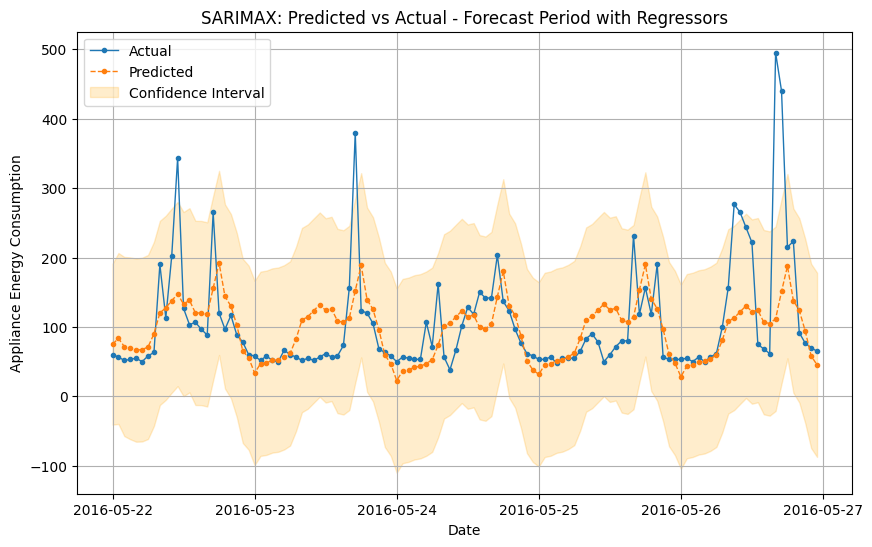

MAE: 41.63, MSE: 4683.83, RMSE: 68.44


In [11]:
# Plot Actual vs Predicted for the forecast period
plt.figure(figsize=(10, 6))
plt.plot(test_data['Appliances'].iloc[:forecast_horizon], label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(forecasted_values2, label='Predicted', marker='.', linestyle='--', linewidth=1)
plt.fill_between(
    forecast_conf_int2.index,
    forecast_conf_int2.iloc[:, 0],
    forecast_conf_int2.iloc[:, 1],
    color='orange',
    alpha=0.2,
    label='Confidence Interval'
)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('SARIMAX: Predicted vs Actual - Forecast Period with Regressors')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate Forecast Accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_data['Appliances'].iloc[:forecast_horizon], forecasted_values2)
mse = mean_squared_error(test_data['Appliances'].iloc[:forecast_horizon], forecasted_values2)
rmse = mse ** 0.5

print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

In [12]:
# Evaluate Forecast Accuracy for the second SARIMAX model with regressors
mape2 = (abs((test_data['Appliances'].iloc[:forecast_horizon] - forecasted_values2) /
             test_data['Appliances'].iloc[:forecast_horizon]).mean()) * 100

r2_2 = r2_score(test_data['Appliances'].iloc[:forecast_horizon], forecasted_values2)

# Update the error metrics DataFrame
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'SARIMAX with Regressors',
    'MAPE': mape2,
    'R2': r2_2
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)


                        Model       MAPE        R2
0  SARIMAX without Regressors  44.958052  0.257549
1     SARIMAX with Regressors  38.345704  0.260470


## Random Forest Model

### RF without Regressors

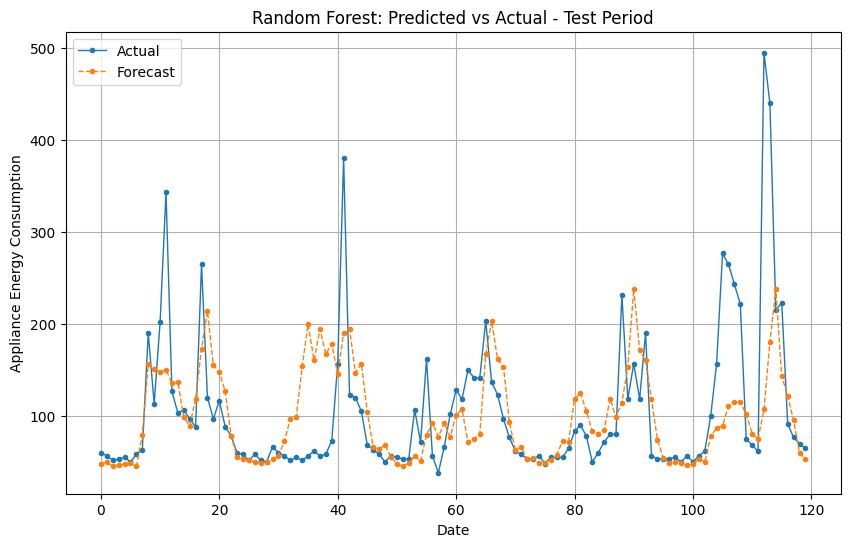

In [13]:
# Prepare features and target
X_train = categorical_vars
y_train =  train_data['Appliances'] 

X_test = test_categorical_vars
y_test = test_data['Appliances'] 

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Fit the model

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(y_pred_rf, label='Forecast', marker='.', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('Random Forest: Predicted vs Actual - Test Period')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Error Metrics
mape_rf = (abs((y_test - y_pred_rf) / y_test).mean()) * 100
r2_rf = r2_score(y_test, y_pred_rf)

# Save metrics for Random Forest
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'Random Forest without Regressors',
    'MAPE': mape_rf,
    'R2': r2_rf
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)

                              Model       MAPE        R2
0        SARIMAX without Regressors  44.958052  0.257549
1           SARIMAX with Regressors  38.345704  0.260470
2  Random Forest without Regressors  37.583195  0.212407


### RF with Regressors

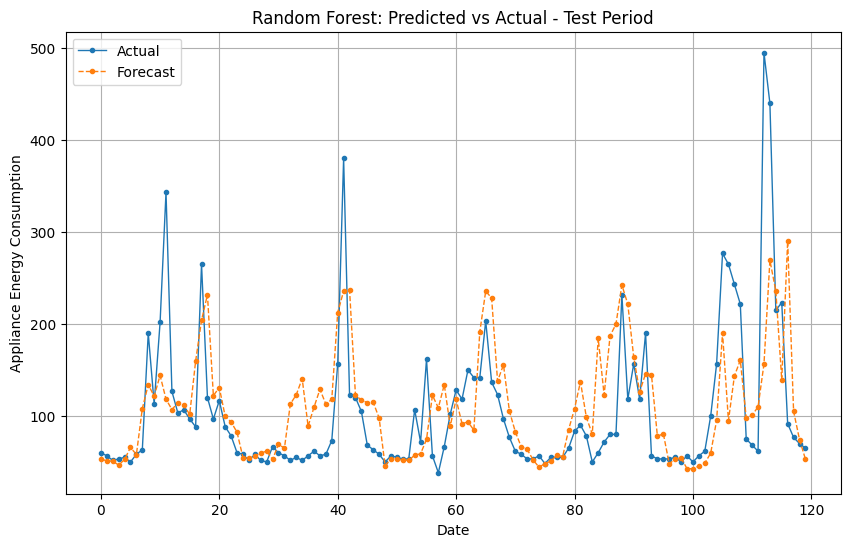

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare features and target
X_train = exog_vars
y_train =  train_data['Appliances'] 

X_test = forecasted_regressors
y_test = test_data['Appliances'] 

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Fit the model

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(y_pred_rf, label='Forecast', marker='.', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('Random Forest: Predicted vs Actual - Test Period')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# Error Metrics
mape_rf2 = (abs((y_test - y_pred_rf) / y_test).mean()) * 100
r2_rf2 = r2_score(y_test, y_pred_rf)

# Save metrics for Random Forest
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'Random Forest with Regressors',
    'MAPE': mape_rf2,
    'R2': r2_rf2
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)

                              Model       MAPE        R2
0        SARIMAX without Regressors  44.958052  0.257549
1           SARIMAX with Regressors  38.345704  0.260470
2  Random Forest without Regressors  37.583195  0.212407
3     Random Forest with Regressors  41.789437  0.305734


## XGBoost Model

### XGBoost without Regressors

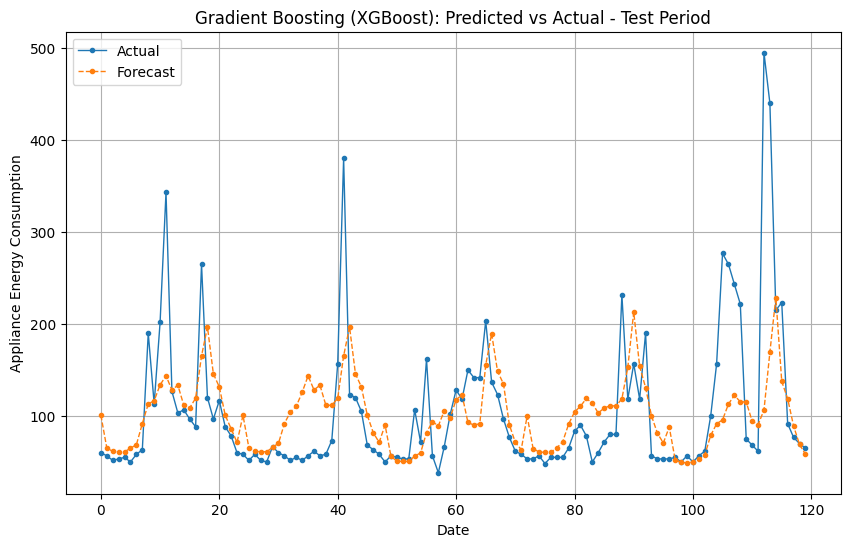

In [17]:
from xgboost import XGBRegressor

# Define features and target for training and testing
X_train = categorical_vars
y_train =  train_data['Appliances'] 

X_test = test_categorical_vars
y_test = test_data['Appliances'] 

# Train Gradient Boosting Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(y_pred_xgb, label='Forecast', marker='.', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('Gradient Boosting (XGBoost): Predicted vs Actual - Test Period')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Evaluate the model
mape_xgb = (abs((y_test - y_pred_xgb) / y_test).mean()) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)

# Save metrics for Gradient Boosting
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'XGBoost without Regressors',
    'MAPE': mape_xgb,
    'R2': r2_xgb
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)

                              Model       MAPE        R2
0        SARIMAX without Regressors  44.958052  0.257549
1           SARIMAX with Regressors  38.345704  0.260470
2  Random Forest without Regressors  37.583195  0.212407
3     Random Forest with Regressors  41.789437  0.305734
4        XGBoost without Regressors  38.094793  0.259017


### XGBoost with Regressors

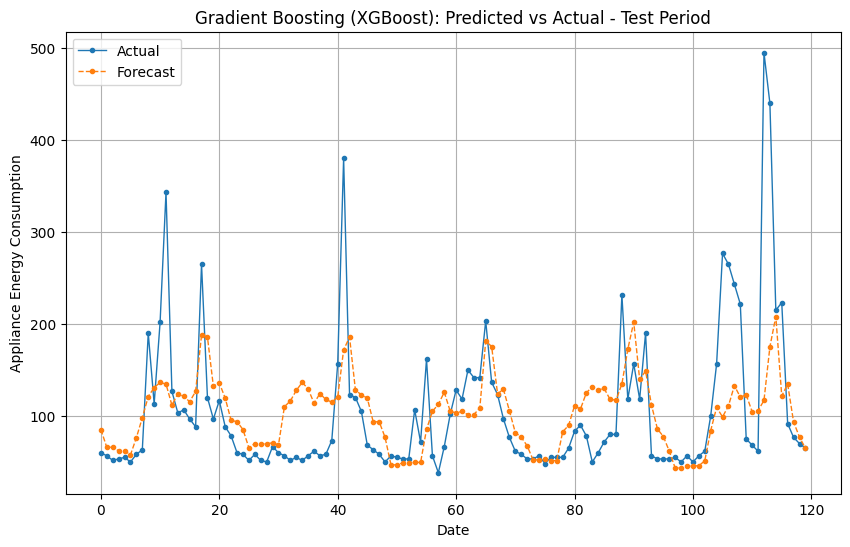

In [19]:
from xgboost import XGBRegressor

# Define features and target for training and testing
X_train = exog_vars
y_train =  train_data['Appliances'] 

X_test = forecasted_regressors
y_test = test_data['Appliances'] 

# Train Gradient Boosting Model
xgb_model2 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model2.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model2.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(y_pred_xgb, label='Forecast', marker='.', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('Gradient Boosting (XGBoost): Predicted vs Actual - Test Period')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Evaluate the model
mape_xgb2 = (abs((y_test - y_pred_xgb) / y_test).mean()) * 100
r2_xgb2 = r2_score(y_test, y_pred_xgb)

# Save metrics for Gradient Boosting
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'XGBoost with Regressors',
    'MAPE': mape_xgb2,
    'R2': r2_xgb2
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)

                              Model       MAPE        R2
0        SARIMAX without Regressors  44.958052  0.257549
1           SARIMAX with Regressors  38.345704  0.260470
2  Random Forest without Regressors  37.583195  0.212407
3     Random Forest with Regressors  41.789437  0.305734
4        XGBoost without Regressors  38.094793  0.259017
5           XGBoost with Regressors  42.073423  0.271659


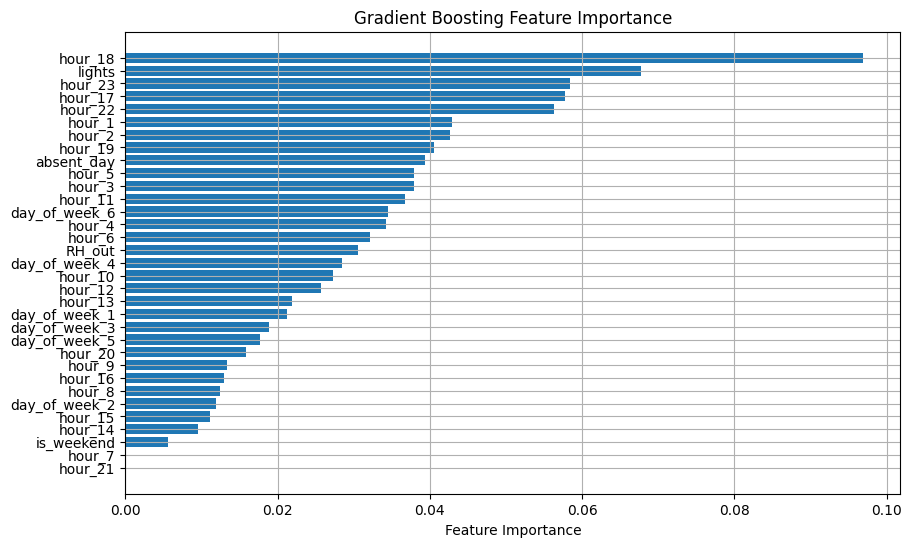

In [21]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = xgb_model2.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(exog_vars.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Gradient Boosting Feature Importance')
plt.grid(True)
plt.show()


## Model Comparison

An energy company with a goal to predict energy consumption of a household is more likely to minimize errors and rather than explaining the thourly variability. Therefore, I generated a weighted error metric with 75% weight on MAPE and 25% weight on R2. Below table is sorted the models from best to worst performers: 

In [22]:
# Calculate weighted_metric
error_metrics_df['weighted_metric'] = 0.75 * (1 - (error_metrics_df['MAPE'] / 100)) + 0.25 * error_metrics_df['R2']

# Sort the DataFrame by weighted_metric in ascending order
error_metrics_df = error_metrics_df.sort_values(by='weighted_metric', ascending=False)

# Reset index for cleaner display
error_metrics_df.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(error_metrics_df)

                              Model       MAPE        R2  weighted_metric
0        XGBoost without Regressors  38.094793  0.259017         0.529043
1           SARIMAX with Regressors  38.345704  0.260470         0.527525
2  Random Forest without Regressors  37.583195  0.212407         0.521228
3     Random Forest with Regressors  41.789437  0.305734         0.513013
4           XGBoost with Regressors  42.073423  0.271659         0.502364
5        SARIMAX without Regressors  44.958052  0.257549         0.477202


We see the external regressors help with SARIMAX but not with XGB and RF models. This might be due to the fact that non-linear models are misguided byt the confounded errors in the forecasted regressors. 

## Alternative Model without categorical Dummies

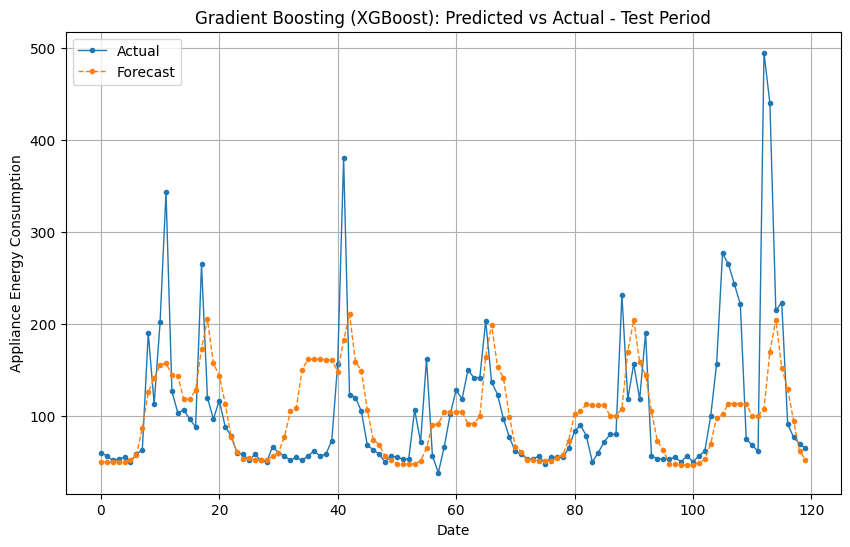

In [23]:
categorical_vars = train_data[['day_of_week', 'hour', 'is_weekend', 'absent_day']]
test_categorical_vars = test_data[['day_of_week', 'hour', 'is_weekend', 'absent_day']]
# Define features and target for training and testing
X_train = categorical_vars
y_train =  train_data['Appliances'] 

X_test = test_categorical_vars
y_test = test_data['Appliances'] 

# Train Gradient Boosting Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(y_pred_xgb, label='Forecast', marker='.', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('Gradient Boosting (XGBoost): Predicted vs Actual - Test Period')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Evaluate the model
mape_xgb = (abs((y_test - y_pred_xgb) / y_test).mean()) * 100
r2_xgb = r2_score(y_test, y_pred_xgb)
weighted_metric = 0.75 * (1 - mape_xgb/100) + 0.25 * r2_xgb
error_metrics_df= error_metrics_df.iloc[:-1]
# Save metrics for Gradient Boosting
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'XGBoost without Regressors and Dummys',
    'MAPE': mape_xgb,
    'R2': r2_xgb, 
    'weighted_metric' : weighted_metric
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)

                                   Model       MAPE        R2  weighted_metric
0             XGBoost without Regressors  38.094793  0.259017         0.529043
1                SARIMAX with Regressors  38.345704  0.260470         0.527525
2       Random Forest without Regressors  37.583195  0.212407         0.521228
3          Random Forest with Regressors  41.789437  0.305734         0.513013
4                XGBoost with Regressors  42.073423  0.271659         0.502364
5             SARIMAX without Regressors  44.958052  0.257549         0.477202
6  XGBoost without Regressors and Dummys  37.672734  0.236728         0.526637


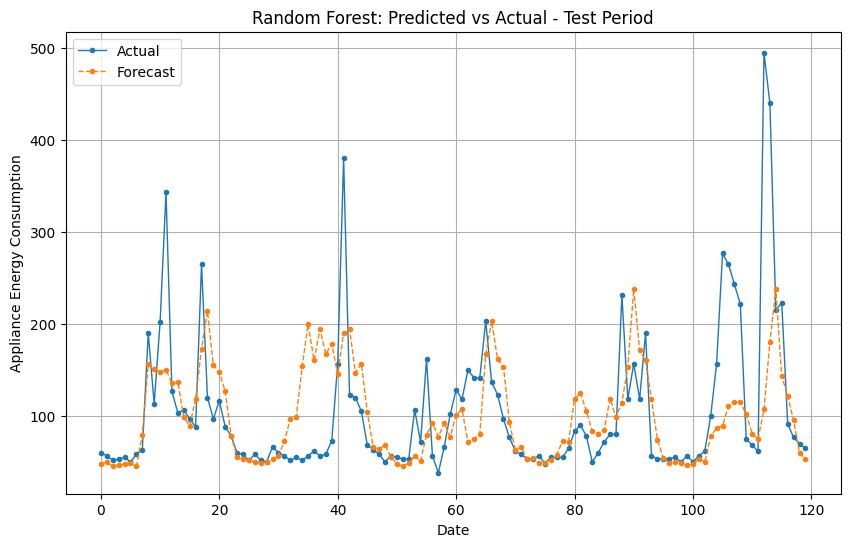

In [29]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Fit the model

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', marker='.', linestyle='-', linewidth=1)
plt.plot(y_pred_rf, label='Forecast', marker='.', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Appliance Energy Consumption')
plt.title('Random Forest: Predicted vs Actual - Test Period')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Evaluate the model
mape_rf = (abs((y_test - y_pred_rf) / y_test).mean()) * 100
r2_rf = r2_score(y_test, y_pred_rf)
weighted_metric_rf = 0.75 * (1 - mape_rf/100) + 0.25 * r2_rf

# Save metrics for Gradient Boosting
error_metrics_df = pd.concat([error_metrics_df, pd.DataFrame([{
    'Model': 'RF without Regressors and Dummys',
    'MAPE': mape_rf,
    'R2': r2_rf, 
    'weighted_metric' : weighted_metric_rf
}])], ignore_index=True)

# Display the updated metrics
print(error_metrics_df)

                                   Model       MAPE        R2  weighted_metric
0             XGBoost without Regressors  38.094793  0.259017         0.529043
1                SARIMAX with Regressors  38.345704  0.260470         0.527525
2       Random Forest without Regressors  37.583195  0.212407         0.521228
3          Random Forest with Regressors  41.789437  0.305734         0.513013
4                XGBoost with Regressors  42.073423  0.271659         0.502364
5             SARIMAX without Regressors  44.958052  0.257549         0.477202
6  XGBoost without Regressors and Dummys  37.672734  0.236728         0.526637
7       RF without Regressors and Dummys  37.583195  0.212407         0.521228


If the number of models and the required computation power are limited, the XGB model without the regressors and dummy categorical variables is the best model. 